<a href="https://colab.research.google.com/github/nikewinchester/NLPTextSummarization/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Installing and Importing necessary libraries**

In [ ]:
!pip install -U sentence-transformers
!pip install rake-nltk

Requirement already up-to-date: sentence-transformers in /usr/local/lib/python3.7/dist-packages (1.1.1)


In [ ]:
!pip install spacy

In [ ]:
import pandas as pd
import seaborn as sns
import re
import string
from string import punctuation
import nltk
import spacy
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from nltk import tokenize
from operator import itemgetter
import math
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english'))
from rake_nltk import Rake
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from numpy import unique
from spacy.lang.en import English

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## **Reading the Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data=pd.read_csv("/content/drive/MyDrive/drugsComTest_raw.csv")

## **Pre-processing the data**

### **Removing symbols**

In [ ]:
df=pd.DataFrame(data=(data["drugName"],data["review"]))
df=df.T
for i in df.index:
  df['review'][i]=df['review'][i].replace("&#039;","'")
  df['review'][i]=df['review'][i].replace(",","")
  df['review'][i]=df['review'][i].replace("\\","")
  df['review'][i]=df['review'][i].replace("\"","")
  df['review'][i]=df['review'][i].replace("\"]","")
  df['review'][i]=df['review'][i].replace("[\"","")
  df['review'][i]=df['review'][i].replace("!",".")
  df['review'][i]=df['review'][i].replace("?",".")
df

,drugName,review
0,Mirtazapine,I've tried a few antidepressants over the year...
1,Mesalamine,My son has Crohn's disease and has done very w...
2,Bactrim,Quick reduction of symptoms
3,Contrave,Contrave combines drugs that were used for alc...
4,Cyclafem 1 / 35,I have been on this birth control for one cycl...
...,...,...
53761,Tamoxifen,I have taken Tamoxifen for 5 years. Side effec...
53762,Escitalopram,I've been taking Lexapro (escitaploprgram) sin...
53763,Levonorgestrel,I'm married 34 years old and I have no kids. T...
53764,Tapentadol,I was prescribed Nucynta for severe neck/shoul...


### **Grouping the data by medicine names**

In [ ]:
df2 = df.groupby("drugName")
df_new = df2["review"].apply(list)
df_new = df_new.reset_index()
df_new

,drugName,review
0,A / B Otic,[These drops helped me so much. I was in sever...
1,Abacavir / dolutegravir / lamivudine,[I discovered my new status in July 2017 VL 94...
2,Abacavir / lamivudine,[I've used this since first diagnosed and star...
3,Abatacept,[In UK had this on NHS for last 7 months. Impr...
4,Abilify,[After having to pay a but load out of pocket ...
...,...,...
2632,ZzzQuil,[Gave me rapid heart beats .........]
2633,depo-subQ provera 104,[Just recently have got Depo subQ provera for ...
2634,ella,[Hello strangers. Im here to share my experien...
2635,femhrt,[Hot flashes completely gone in less than 2 we...


### **Stopword Removal and Parsing**

In [ ]:
def get_text_processing(text):
    stpword = stopwords.words('english')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    #nlp = English()
    #doc = nlp(' '.join([word for word in no_punctuation.split() if word.lower() not in stpword]))
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

### **Creating a separate column for the refined text**

In [ ]:
df_new['rev'] = df_new['review'].apply(get_text_processing)
df_new.head()

,drugName,review,rev
0,A / B Otic,[These drops helped me so much. I was in sever...,drops helped much. severe pain 8 days finally ...
1,Abacavir / dolutegravir / lamivudine,[I discovered my new status in July 2017 VL 94...,discovered new status July 2017 VL 94K CD4 126...
2,Abacavir / lamivudine,[I've used this since first diagnosed and star...,I've used since first diagnosed starting HAART...
3,Abatacept,[In UK had this on NHS for last 7 months. Impr...,UK NHS last 7 months. Improved within first mo...
4,Abilify,[After having to pay a but load out of pocket ...,pay load pocket slowly found me. put hyper-man...


## **Feature Extraction**

### **Extracting keywords using BERT and RAKE**

In [ ]:
bertmodel = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [ ]:
def key(text):
  r = Rake()
  temp=text.split(' ')
  a=[]
  r.extract_keywords_from_sentences(temp)
  # To get keyword phrases ranked highest to lowest.
  r.get_ranked_phrases()
  rakew=[]
  # To get keyword phrases ranked highest to lowest with scores.
  a=r.get_ranked_phrases()
  t = 20
  if(len(a)<20):
    t = len(a)
  for i in range(0,t):
    rakew.append(a[i])
  
  temp=text.split(".")
  all_words = [i for i in temp]
  sent_vector=[]
  temp=text.split(".")
  t=''
  for i in temp:
    t+=i

  n_gram_range = (1, 1)
  stop_words = "english"

  # Extract candidate words/phrases
  count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([t])
  candidates = count.get_feature_names()

  doc_embedding = bertmodel.encode([t])
  candidate_embeddings = bertmodel.encode(candidates)

  top_n = 15
  distances = cosine_similarity(doc_embedding, candidate_embeddings)
  keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]

  f_keywords = list(keywords+rakew)

  return f_keywords

### **Calculating TF-IDF values for the keywords**

In [ ]:
def check_sent(word, sentences): 
    final = [all([w in x for w in word]) for x in sentences] 
    sent_len = [sentences[i] for i in range(0, len(final)) if final[i]]
    return int(len(sent_len))

def get_top_n(dict_elem, n):
    result = dict(sorted(dict_elem.items(), key = itemgetter(1), reverse = True)[:n]) 
    return result.keys()
    
def caltfidf(total_words,text):
  total_word_length = len(total_words)
  total_sentences = tokenize.sent_tokenize(text)
  total_sent_len = len(total_sentences)

  tf_score = {}
  for each_word in total_words:
      each_word = each_word.replace('.','')
      if each_word not in stop_words:
          if each_word in tf_score:
              tf_score[each_word] += 1
          else:
              tf_score[each_word] = 1

  # Dividing by total_word_length for each dictionary element
  tf_score.update((x, y/int(total_word_length)) for x, y in tf_score.items())

  idf_score = {}
  for each_word in total_words:
      each_word = each_word.replace('.','')
      if each_word not in stop_words:
          if each_word in idf_score:
              idf_score[each_word] = check_sent(each_word, total_sentences)
          else:
              idf_score[each_word] = 1

  # Performing a log and divide
  idf_score.update((x, math.log(int(total_sent_len)/y)) for x, y in idf_score.items())


  tf_idf_score = {key: tf_score[key] * idf_score.get(key, 0) for key in tf_score.keys()}

  t = 25
  if(len(tf_idf_score)<25):
    t = len(tf_idf_score)

  tfidfw=list(get_top_n(tf_idf_score, t))
  return tfidfw

### **POS Tagging the resultant keywords**

In [ ]:
def features(text):
  f_keywords = key(text)
  tfidfw = caltfidf(f_keywords,text)
  tfidfw = " ".join(tfidfw)

  stop_words = set(stopwords.words('english'))

  tokenized = sent_tokenize(tfidfw)

  for i in tokenized:
    wordsList = nltk.word_tokenize(i)

    wordsList = [w for w in wordsList if not w in stop_words]

    tagged = nltk.pos_tag(wordsList)


  
  for i in range(0,len(tagged)):
    if(tagged[i][1]=='JJ' or tagged[i][1]=='NN' or tagged[i][1]=='VBP' or tagged[i][1]=='VBG'):
      print(tagged[i][0])

### **Removing Stopwords from the given text**

In [ ]:
def findFeatures(text):
    stpword = stopwords.words('english')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    finalText = ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

    features(finalText)

### **Feature Extraction for the reviews from the dataset**

In [ ]:
test = 7
text = ' '.join([line for line in df_new['review'][test]])
features(text)

prostate
hot
night
bone
month
medicine
cancer
zytiga
thickness
take
symptom
swollen
side


### **Feature Extraction for user input text**

In [ ]:
text = "The surface level is the actual realization of words as they appear in the final form. The lexical level corresponds to the combination of roots and affixes that are chained together with boundary markers."
findFeatures(text)

combination
actual
appear
affixes
level
form
realization
final
surface
lexical
boundary


## **Text Summarization**

In [ ]:
def Summarizer(test):
  df_new["review"][test]
  sentence = sent_tokenize(str(df_new["review"][test]))
  temp=df_new["rev"][test].split(".")
  all_words = [i for i in temp]
  sent_vector=[]
  for i in temp:
      plus=0
      for j in i.split("."):
          plus+= bertmodel.encode(j)
      plus = plus/len(i.split("."))
      sent_vector.append(plus)
  n_clusters = 3

  kmeans = KMeans(n_clusters, init = 'k-means++', random_state = 42)
  y_kmeans = kmeans.fit_predict(sent_vector)
  my_list=[]
  for i in range(n_clusters):
      my_dict={}
    
      for j in range(len(y_kmeans)):
        
          if y_kmeans[j]==i:
              my_dict[j] =  distance.euclidean(kmeans.cluster_centers_[i],sent_vector[j])
      min_distance = min(my_dict.values())
      my_list.append(min(my_dict, key=my_dict.get))

  km = []                          
  for i in sorted(my_list):
      try:
        km.append(sentence[i])
      except:
        pass


  model = AgglomerativeClustering(n_clusters=3)
  # fit model and predict clusters
  yhat = model.fit_predict(sent_vector)
  # retrieve unique clusters
  clusters = unique(yhat)


  my_list=[]
  for i in range(n_clusters):
      my_dict={}
    
      for j in range(len(yhat)):
        
          if yhat[j]==i:
              my_dict[j] =  distance.euclidean(clusters[i],sent_vector[j])
      min_distance = min(my_dict.values())
      my_list.append(min(my_dict, key=my_dict.get))

  ag = []                          
  for i in sorted(my_list):
      ag.append(sentence[i])

  final_summary = list(set(km+ag))
  print("Summary:")
  for i in final_summary:
    print(i, end=' ')
  print("\n")

In [ ]:
medicine_name = "Acanya"
ind = df_new[df_new['drugName']==medicine_name].index.values
test = ind[0]
print("\nMedicine Name: ", medicine_name)
print("\nReview: ", ' '.join(df_new['review'][test]), "\n")
Summarizer(test)
print("\nKeywords: ")
findFeatures(df_new['review'][test])


Medicine Name:  Acanya

Review:  Honestly this medicine has been life changing for me. Before I used it my acne was awful mostly on my forehead but all around the rest of my face too. My dermatologist prescribed it to me and within a month of using it my acne completely cleared up. Now three years later I still use it and my face remains acne free. I was breaking out badly on the sides of my cheeks then I couldn't take it anymore so I went to the dermo and they prescribed me Acanya. After 2 weeks I noticed a difference for sure. The big cysts I would get or just all these pimples I got in 1 spot started fading away instantly. It is take time I had to pop some and then put the cream on. It's been 3 months so far and no breakouts or acne whatsoever. I just use cetaphil and that medication and done. (: I LOVE this product. I suffered from breakouts (not horrible) but enough to make me self-conscious about. It does not make your face dry if anything it smooths it out. I use a tad in the m

In [ ]:
medicine_name = "Acetaminophen / propoxyphene"
ind = df_new[df_new['drugName']==medicine_name].index.values
test = ind[0]
print("\nMedicine Name: ", medicine_name)
print("\nReview: ", ' '.join(df_new['review'][test]), "\n")
Summarizer(test)
print("\nKeywords: ")
findFeatures(df_new['review'][test])


Medicine Name:  Acetaminophen / propoxyphene

Review:  I just got my wisdom teeth out and I'm allergic to codeine so the doctor gave me Darvocet. It doesn't make me sleepy but I am dizzy and find complex problem-solving difficult. It helps ease some of the sharp pains in my jaw but I still have a dull throbbing pain that keeps me from sleeping. If only Vicodin didn't make me vomit. I broke my back when I was 16 and have had a total of 26 surgeries in my life. Have taken Darvocet for 46 yrs now and it has saved the day. This is okay if you have a minor headache but it's very weak. I had a Hematoma when I was pregnant and they would only give this to me and it still didn't get rid of the pain and that was PAINFUL. Thought I was having a miscarriage when it first came on. I would definitely not recommend this for anything other than headaches. I have been on and off this drug in some form for over 40 years. I have had no problems of any kind.
I am taking generic Butalbital Comp-Codeine #

## **Future Improvements (LSTM)**

In [ ]:
X=[]
y=[]
for test in range(0,len(df_new)):
  try:
    stri=''
    for sen in df_new["review"][test]:
      stri=stri+sen
    stri=stri.split(".")
    stri.pop()
    sentence = sent_tokenize(str(df_new["review"][test]))
    temp=df_new["rev"][test].split(".")
    temp.pop()
    length=len(temp)
    if (length == 1):
      temp[0]+="."
    all_words = [i for i in temp]
    sent_vector=[]
    for i in temp:
        plus=0
        for j in i.split("."):
            plus+= embedder.encode(j)
        plus = plus/len(i.split("."))
        sent_vector.append(plus)
    n_clusters = (int)(length/5)+1
    kmeans = KMeans(n_clusters, init = 'k-means++', random_state = 42)
    y_kmeans = kmeans.fit_predict(sent_vector)
    my_list=[]
    for i in range(n_clusters):
        my_dict={}
      
        for j in range(len(y_kmeans)):
          
            if y_kmeans[j]==i:
                my_dict[j] =  distance.euclidean(kmeans.cluster_centers_[i],sent_vector[j])
        min_distance = min(my_dict.values())
        my_list.append(min(my_dict, key=my_dict.get))
    temp=""
    for i in stri:
      temp+=i
    X.append(temp)
    temp="start "                        
    for i in sorted(my_list):
        if (i>=0):
          temp+=stri[i]
    temp+=" end"
    y.append(temp)
  except:
    pass

In [ ]:
dict = {'Text': X, 'Summary': y}    
df = pd.DataFrame(dict)
df.to_csv('/content/drive/MyDrive/Testtrainsummary.csv')

In [ ]:
dat=pd.read_csv("/content/drive/MyDrive/Testtrainsummary.csv")

In [ ]:
X=dat["Text"]
y=dat["Summary"]

In [ ]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from attention import AttentionLayer
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

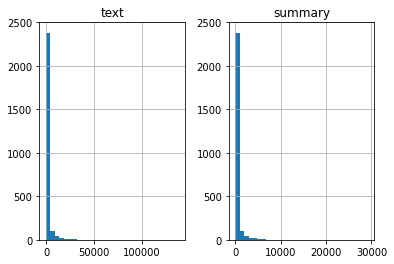

In [ ]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in X:
      text_word_count.append(len(i.split()))

for i in y:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [ ]:
max_len_text=600 
max_len_summary=150

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(X,y,test_size=0.1,random_state=0,shuffle=True) 

In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [ ]:

#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [ ]:

from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.5) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.5) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.5) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 600, 500)     29193500    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 600, 500), ( 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath = "/content/drive/MyDrive/model_training.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss',
                             verbose=1, save_best_only=True,
                             mode='min')

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=12,callbacks = [checkpoint],batch_size=32, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
73/73 [==============================] - 209s 3s/step - loss: 3.4130 - accuracy: 0.5114 - val_loss: 3.5687 - val_accuracy: 0.4780

Epoch 00001: loss improved from inf to 3.41301, saving model to /content/drive/MyDrive/model_training.hdf5
Epoch 2/50
73/73 [==============================] - 208s 3s/step - loss: 3.2680 - accuracy: 0.5192 - val_loss: 3.4340 - val_accuracy: 0.4892

Epoch 00002: loss improved from 3.41301 to 3.26802, saving model to /content/drive/MyDrive/model_training.hdf5
Epoch 3/50
73/73 [==============================] - 208s 3s/step - loss: 3.1349 - accuracy: 0.5303 - val_loss: 3.3496 - val_accuracy: 0.5006

Epoch 00003: loss improved from 3.26802 to 3.13490, saving model to /content/drive/MyDrive/model_training.hdf5
Epoch 4/50
73/73 [==============================] - 208s 3s/step - loss: 3.0196 - accuracy: 0.5404 - val_loss: 3.2652 - val_accuracy: 0.5083

Epoch 00004: loss improved from 3.13490 to 3.01958, saving model to /content/drive/MyDrive/model_traini

In [ ]:
model.save("/content/drive/MyDrive/fmodel1.hdf5")

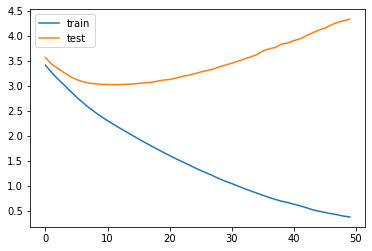

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [ ]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token'
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if (sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0,10):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

Review: needed to use the remaining suppositories due to itching and minor bleeding from hard stool noticed blood sugar rising about 40 pts now that i stopped using it condition somewhat better and sugars are lower 
Original summary: needed to use the remaining suppositories due to itching and minor bleeding from hard stool 
Predicted summary:  i was in a few more weeks to the pharmacy i'm not sure how this is the job of my life as soon as i stopped it as it was no longer falling off i think it is a strong drug with it


Review: this is my second go around with this medicine my sugars stay in the 200's it makes me eat all the is an excellent addition to my regimen in controlling my i have experienced weight loss and it is very affordable my doctor gave me a value card which fixes the co pay at just 10 per month at last a new medicine that works and is affordablei am a type 2 diabetic for 13 years insulins lantus and novolog flex pen actos metformin sugar was still high a1c 119 i know i

Review: exceptionally good product to relieve mild dermatitis symptoms it has come in 2 part a large bottle of liquid and a capsule of the active ingredient if you are not going to use the product immediately tell the pharmacist to not mix the products for you the solution is good only for 3 months from the date of on holiday in hot sunny climates i always suffer from severe heat rash after using synalar cream it clears after a day or so it is brilliant 




Original summary: when on holiday in hot sunny climates i always suffer from severe heat rash after using cream it clears after a day or so it is brilliant 




Predicted summary:  i have yellow problems with less side effects than the way of them it was the most effective medication i've tried the top of the skin it has less dry and less than when i was able to get rid of the pills of the 250 mg advair i give it a 10 out of it for about ten days i had an allergic reaction to the medicine i had the nausea some way it subsided the first two days about 3 days later and my skin has improved and my cancer was approved by the way as the medicine lasts a good pills at least but as the results it has gotten so much better than some of the nausea or not the relief i had some noticeable side effects that i had some relief from the first two weeks in the past